Problem


Construct 2-layer perceptron with MNIST data set from Kaggle.


Use ReLU as activation function, softmax to classify, cross entroy as cost function

The goal is to take an image of a handwritten single digit, and determine what that digit is.


For every in the test set, you should predict the correct label.

In [11]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [12]:
train=pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [13]:
Label = train['label'].values
Train = train.drop(columns=['label']).values/255
Test = test.values/255
[N,size_input]=Train.shape

In [14]:
def ReLU(x):
    return np.maximum(0,x)

def d_ReLU(x):
    return x>0

In [15]:
def loss(pred,Label):
    true = np.eye(num_class)[Label]
    loss = (np.log(pred) * true).sum(axis=1)
    return -np.sum(loss)

In [16]:
def feed(Input,Matrix,bias):
    Hidden = np.dot(Input, Matrix[0]) + bias[0]
    z_1=Hidden
    
    Activation = ReLU(z_1)
    z_2=np.dot(Activation,Matrix[1])
    
    #Softmax Part
    s=np.exp(z_2)
    total = np.sum(s, axis=1).reshape(-1,1)
    Output = s/total
    return Output,Activation,z_1

In [17]:
def backprop(Matrix,bias,Input,Label):
    #step 1
    Output,Activate_1,z_1 = feed(Input,Matrix,bias)
    
    #step 2 Output from Hidden derivative
    true = np.eye(num_class)[Label]
    # \part cost / \part z_2 is delta _ H2O
    # \part z_2  / \part Matrix[1] is grad_H2O
    delta_H2O = (Output -true)
    grad_H2O = np.dot(Activate_1.T, delta_H2O)
    
    #step 3 Hidden from Input derivative
    delta_I2H = np.dot(delta_H2O, Matrix[1].T)*d_ReLU(z_1)
    grad_I2H = np.dot(Input.T, delta_I2H)
    
    dMatrix = [grad_I2H/N, grad_H2O/N]
    dbias = [np.mean(delta_I2H, axis=0)]
    return dMatrix, dbias

Gradient descent optimization

In [18]:
def update (W,b,Train,Label):
    dW, db = backprop(W,b,Train,Label)
    W[0]             -= 0.1 * dW[0]
    W[1]             -= 0.1 * dW[1]
    b[0]             -= 0.1 * db[0]

In [19]:
num_class=10
num_iter = 500
num_Hidden = 256

np.random.seed(1127) #for the experimental stability
#W[0]= Matrix_input_to_Hidden_layer, W[1]= MAtrix_Hidden_to_output_layer
W1= [1e-1*np.random.randn(size_input, num_Hidden), 1e-1*np.random.randn(num_Hidden, num_class)]
b1 = [np.random.randn(num_Hidden)]

In [20]:
%%time
for i in range(num_iter):
    update(W1,b1,Train,Label)
    
    if i % (num_iter/5) == 0:
        # sanity check 1
        prediction,_,_ = feed(Train,W1,b1)
        print("Cross-entropy loss after", i+1, "iterations is {:.8}".format(loss(prediction,Label)))
        print("Training accuracy after", i+1, "iterations is {:.4%}\n".format(np.mean(np.argmax(prediction, axis=1)== Label)))

Final_after_backpropa,_,_ = feed(Train,W1,b1)
print("Final cross-entropy loss is {:.8}".format(loss(Final_after_backpropa,Label)))
print("Final training accuracy is {:.4%}".format(np.mean(np.argmax(Final_after_backpropa, axis=1)== Label)))

Cross-entropy loss after 1 iterations is 108433.42
Training accuracy after 1 iterations is 17.2643%

Cross-entropy loss after 101 iterations is 18009.91
Training accuracy after 101 iterations is 88.2000%

Cross-entropy loss after 201 iterations is 14577.156
Training accuracy after 201 iterations is 90.2048%

Cross-entropy loss after 301 iterations is 13023.488
Training accuracy after 301 iterations is 91.2143%

Cross-entropy loss after 401 iterations is 12012.569
Training accuracy after 401 iterations is 91.8452%

Final cross-entropy loss is 11252.254
Final training accuracy is 92.3619%
CPU times: user 20min 27s, sys: 1min 6s, total: 21min 33s
Wall time: 3min 36s


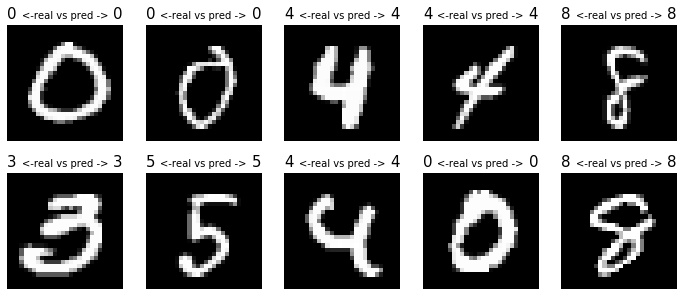

In [57]:
#eye check train set
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,N,size=10)
for i in range(10):
    axes[i].imshow(Train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(Label[idx[i]])), color= 'black',loc='left' ,fontsize=15)
    axes[i].set_title("<-real vs pred ->",color='black',fontsize=10)
    axes[i].set_title(str(int(np.argmax(Final_after_backpropa, axis=1)[idx[i]])),color='black',loc='right',fontsize=15)
plt.show()

In [58]:
#for the test set
Test_submission,_,_ = feed(Test,W1,b1)

In [59]:
M,_=Test.shape

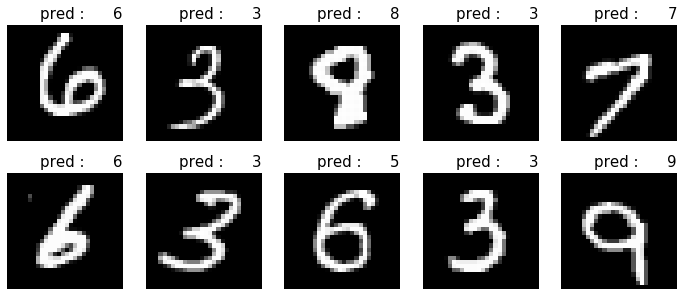

In [64]:
#We don't have test label. So, just for eye check.
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,M,size=10)
for i in range(10):
    axes[i].imshow(Test[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title("pred : ",color='black',fontsize=15)
    axes[i].set_title(str(int(np.argmax(Test_submission, axis=1)[idx[i]])),color='black',loc='right',fontsize=15)
plt.show()

In [68]:
submission = pd.DataFrame({'ImageId': range(1,len(Test)+1) ,'Label': np.argmax(Test_submission,axis=1) })
submission.to_csv("Name_ID_Gradient_result.csv",index=False)
#then you can create Submission file!

Momentum optimization


In [69]:
num_class=10
num_iter = 100
num_Hidden = 256
Momentum=0.9

np.random.seed(1127)
W3 = [1e-1*np.random.randn(size_input, num_Hidden), 1e-1*np.random.randn(num_Hidden, num_class)]
b3 = [np.random.randn(num_Hidden)]

In [70]:
def Momentum_update(W,b,Train,Label,gamma_w0,gamma_w1,gamma_b):
    dW, db = backprop(W,b,Train,Label)
    
    gamma_w0 = Momentum*gamma_w0+0.1*dW[0]
    W[0] -= gamma_w0
    
    gamma_w1 = Momentum*gamma_w1+0.1*dW[1]
    W[1] -= gamma_w1
    
    gamma_b = Momentum*gamma_b+0.1*db[0]
    b[0] -= gamma_b

In [71]:
%%time
gamma_w0=0
gamma_w1=0
gamma_b=0
for i in range(num_iter):
    Momentum_update(W3,b3,Train,Label,gamma_w0,gamma_w1,gamma_b)
    if i % (num_iter/5) == 0:
        # sanity check 1
        prediction,_,_ = feed(Train,W3,b3)
        print("Cross-entropy loss after", i+1, "iterations is {:.8}".format(loss(prediction,Label)))
        print("Training accuracy after", i+1, "iterations is {:.4%}\n".format(np.mean(np.argmax(prediction, axis=1)== Label)))

Final_after_backpropa,_,_ = feed(Train,W3,b3)
print("Final cross-entropy loss is {:.8}".format(loss(Final_after_backpropa,Label)))
print("Final training accuracy is {:.4%}".format(np.mean(np.argmax(Final_after_backpropa, axis=1)== Label)))

Cross-entropy loss after 1 iterations is 108433.42
Training accuracy after 1 iterations is 17.2643%

Cross-entropy loss after 21 iterations is 34650.181
Training accuracy after 21 iterations is 78.7714%

Cross-entropy loss after 41 iterations is 25503.034
Training accuracy after 41 iterations is 84.1000%

Cross-entropy loss after 61 iterations is 21643.178
Training accuracy after 61 iterations is 86.1929%

Cross-entropy loss after 81 iterations is 19451.352
Training accuracy after 81 iterations is 87.3667%

Final cross-entropy loss is 18070.51
Final training accuracy is 88.1476%
CPU times: user 4min 28s, sys: 16 s, total: 4min 44s
Wall time: 47.8 s


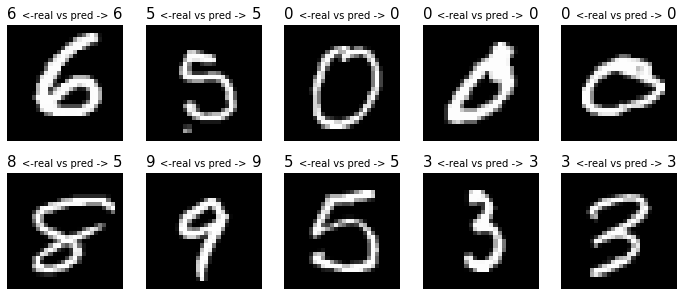

In [72]:
#eye check train set
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,N,size=10)
for i in range(10):
    axes[i].imshow(Train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(Label[idx[i]])), color= 'black',loc='left' ,fontsize=15)
    axes[i].set_title("<-real vs pred ->",color='black',fontsize=10)
    axes[i].set_title(str(int(np.argmax(Final_after_backpropa, axis=1)[idx[i]])),color='black',loc='right',fontsize=15)
plt.show()

In [74]:
Test_submission_Momentum,_,_ = feed(Test,W3,b3)

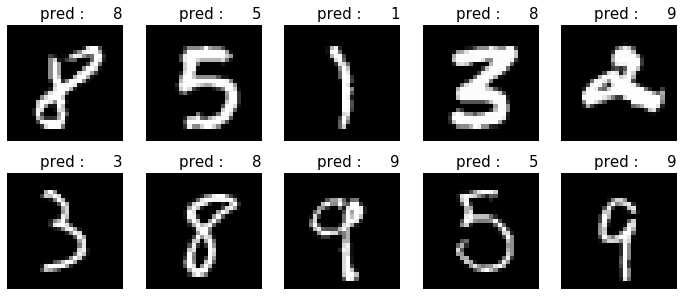

In [75]:
#We don't have test label. So, just for eye check.
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,M,size=10)
for i in range(10):
    axes[i].imshow(Test[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title("pred : ",color='black',fontsize=15)
    axes[i].set_title(str(int(np.argmax(Test_submission_Momentum, axis=1)[idx[i]])),color='black',loc='right',fontsize=15)
plt.show()

In [76]:
submission = pd.DataFrame({'ImageId': range(1,len(Test)+1) ,'Label': np.argmax(Test_submission,axis=1) })
submission.to_csv("Name_ID_Momentum_result.csv",index=False)
#then you can create Submission file!